# 0.0 Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image

import inflection

## 0.1 Helper Functions

In [2]:
def search_outliers(df, series):
    first_quantile = np.quantile(df[series], 0.25)
    third_quantile = np.quantile(df[series], 0.75)
    distance = (third_quantile - first_quantile) * 1.5
    inf_limit = first_quantile - distance
    sup_limit = third_quantile + distance
    index_outliers = df.loc[(df[series]<inf_limit)|(df[series]>sup_limit)].index
    return index_outliers, inf_limit, sup_limit

## 0.2 Loading Data

In [3]:
store = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\store_sales_predict\\store.csv', low_memory=False)
train = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\store_sales_predict\\train.csv', low_memory=False)
test = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\store_sales_predict\\test.csv', low_memory=False)

df = pd.merge(train, store, how='left', on='Store')
df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
382956,860,1,2014-07-28,6506,772,1,1,0,1,c,c,5980.0,2.0,2010.0,0,NaN,NaN,NaN
1015923,944,3,2013-01-02,9470,1560,1,0,0,1,c,a,1670.0,7.0,2015.0,0,NaN,NaN,NaN
397589,463,6,2014-07-12,3973,617,1,0,0,0,a,a,4160.0,NaN,NaN,0,NaN,NaN,NaN
465081,912,7,2014-05-11,0,0,0,0,0,0,c,c,3100.0,5.0,2010.0,0,NaN,NaN,NaN
529646,807,5,2014-03-14,8360,870,1,0,0,0,a,a,3870.0,4.0,2008.0,0,NaN,NaN,NaN


# 1.0 Data Description

## 1.1 Rename Columns

In [4]:
# backup df
df1 = df.copy()

snake_case = lambda x: inflection.underscore(x)

cols_old = df1.columns.to_list()
cols_new = list(map(snake_case, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimension

In [5]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [6]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [7]:
# changing date datatype
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
# competition_distance
df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = 200000

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change Types

In [10]:
backup = df1.copy()

In [11]:
df1 = backup.copy()
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

## 1.7 Descriptive Statistical

### 1.7.1 Classifying Attributes

In [12]:
num_attributes = df1[['sales', 'customers', 'competition_distance']]


cat_attributes = df1[['open', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'day_of_week', 'promo', 'promo2', 'is_promo']].astype('category')

### 1.7.2 Numerical Attributes

In [13]:
# Central Tendendy - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
m.columns = 'min max range mean median std skew kurtosis'.split()
m

,min,max,range,mean,median,std,skew,kurtosis
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712


1. sales: a média e a mediana estão próximas, isso indica uma distribuição centralizada na média, a skew é baixa, o que reforça uma distribuição centralizada na média, indicando uma distribuição próxima a uma normal, a skew é positiva, então tem uma cauda direita um pouco mais pesada, kurtosis próxima de 1, inidica um pico não muito alto. A distribuição deve ser parecida com uma NORMAL.
2. customers: a média e a mediana estão prõximas mas com uma diferença de uns 5 porcento, a skew próxima a 1.5 indica um deslocamento da centralização relativamente pequeno, a skew é positiva, então tem uma cauda direita mais pesada, a kurtosis é média, sugerindo um pico relativamente alto. A distribuição pode ser parecida com uma NORMAL.
3. competition_distance: a média e a mediana estão bastante distantes, a skew é altíssima, o que sugerem que a média e a mediana estão bastante deslocadas, é a skew é positiva, portanto uma cauda direita bem mais pesada, a kurtosis é altíssima, o que aponta um pico bastante alto, com uma alta concentração, não centralizada na média, distribuição parece uma POISSON.

### 1.7.3 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.nunique())

open              2
state_holiday     4
school_holiday    2
store_type        4
assortment        3
day_of_week       7
promo             2
promo2            2
is_promo          2
dtype: int64

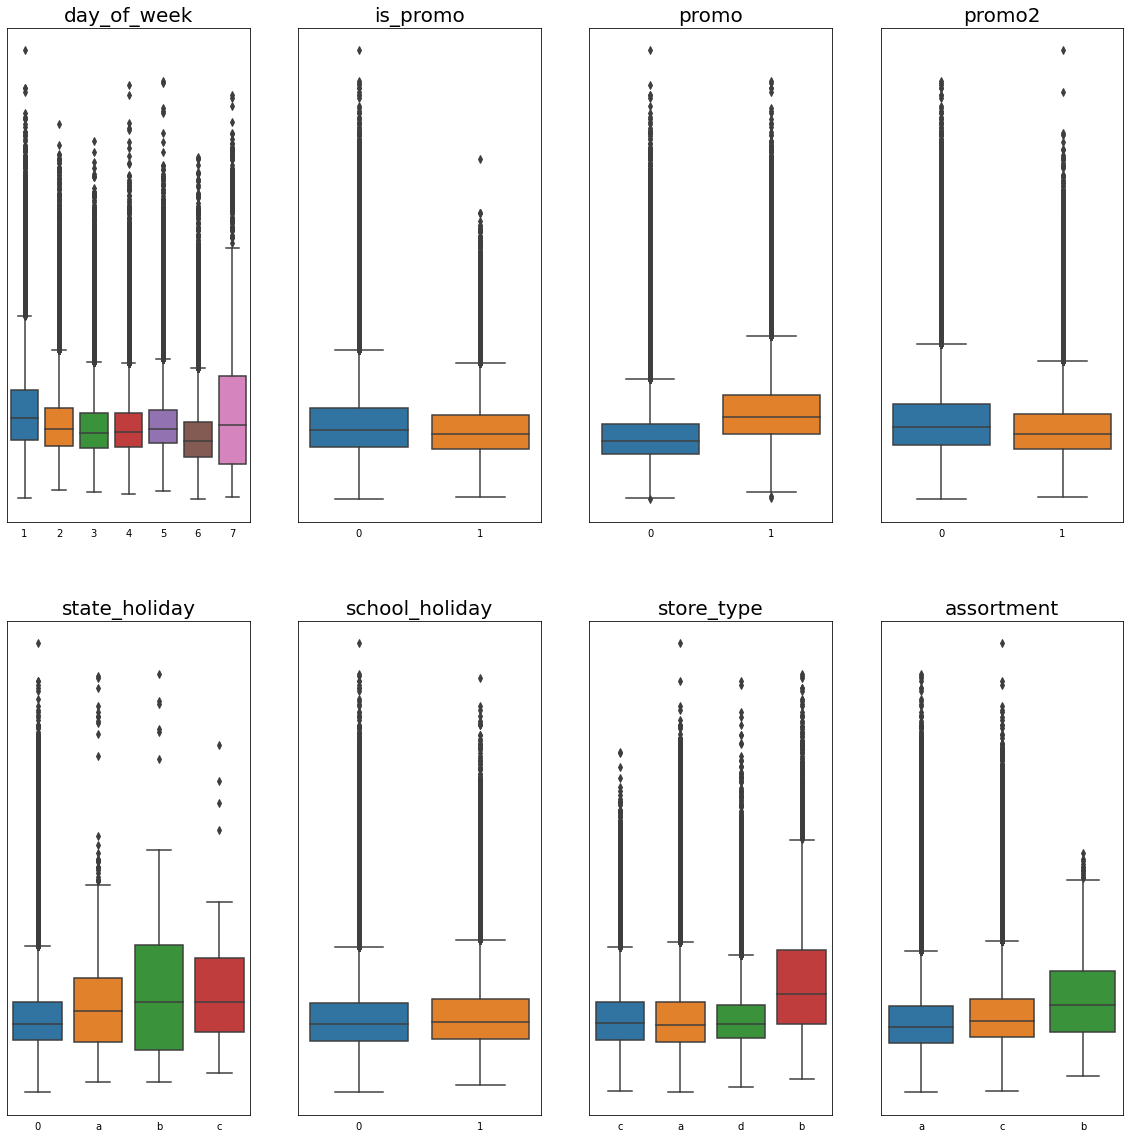

In [15]:
temp = df1.loc[df1['sales'] > 0]

plt.figure(figsize=(20, 20))

plt.subplot(2, 4, 1)
ax = sns.boxplot(x='day_of_week', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('day_of_week', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 2)
ax = sns.boxplot(x='is_promo', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('is_promo', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 3)
ax = sns.boxplot(x='promo', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('promo', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 4)
ax = sns.boxplot(x='promo2', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('promo2', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 5)
ax = sns.boxplot(x='state_holiday', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('state_holiday', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 6)
ax = sns.boxplot(x='school_holiday', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('school_holiday', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 7)
ax = sns.boxplot(x='store_type', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('store_type', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 8)
ax = sns.boxplot(x='assortment', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('assortment', fontsize=20)
plt.xlabel('')
plt.ylabel('');

1. domingos têm uma distribuição mais espalhada, com maior variância
2. promoções do tipo promo aumentam as vendas
4. feriados geram vendas relativamente maiores e com maior variância
6. store_type do tipo b claramente têm maiores vendas

# 2.0 Feature Engineering

## 2.1 Hypothesis Mindmap

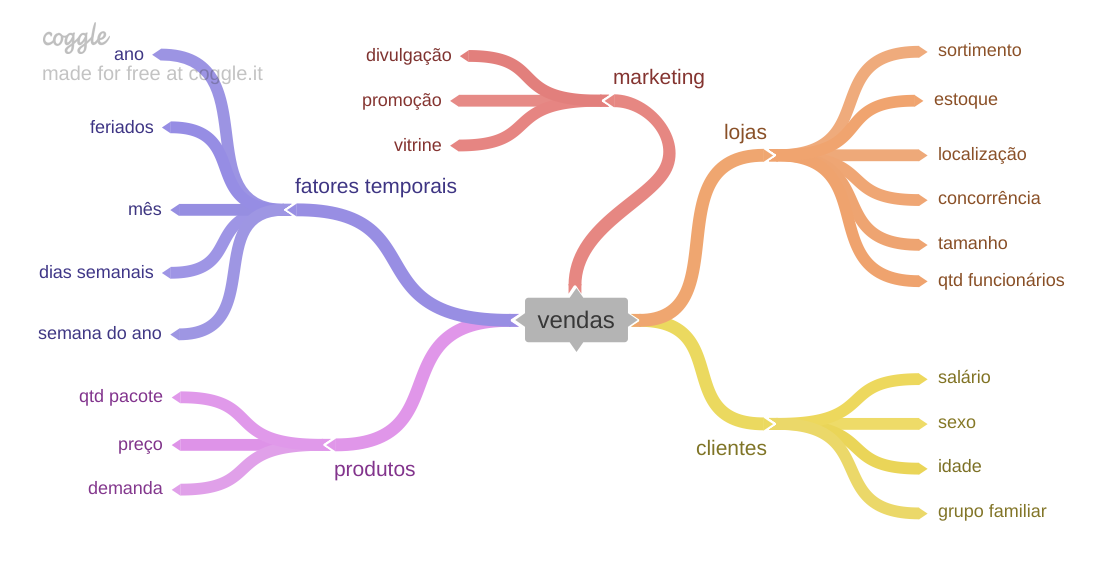

In [16]:
Image('..\\img\\mind_map_hypothesis.png')

## 2.2 Creating Hypothesis List

1. Com o passar dos anos, as vendas devem ser maiores.
2. Aos feriados, as vendas devem ser maiores.
3. As vendas do ultimo trimestre, deveriam ser maiores.
4. Aos finais de semana, as vendas deveriam ser maiores.
5. A ultima semana do MÊS **(corrigir no mindmap)**, deveria vender **MENOS**.
6. Lojas que fazem maior investimento em divulgações, deveriam vender mais.
7. Períodos de promoções, deveriam vender mais.
9. Lojas com promoções a mais tempo, deveriam vender mais.
10. Lojas com melhores estruturas de EXPOSITORES **(corrigir no mindmap)**, deveriam vender mais.
11. Lojas com clientes com maiores salários, deveriam vender mais.
11. Lojas com uma proporção maior de público feminino, deveriam vender mais.
12. Lojas com clientes de faixa etária relativamente maior, deveriam vender mais.
13. Lojas com clientes com grupos familiares maiores, deveriam vender mais.
14. Produtos com pacotes unitários maiores deveriam promover maiores vendas.
15. Produtos com margem de lucro reduzida, deveriam promover maiores vendas.
16. Produtos com maiores demandas, deveriam promover maiores vendas.
17. Lojas com maior sortimento, deveriam vender mais.
18. Lojas com maiores disponibilidades de estoque, deveriam vender mais.
19. Lojas localizadas em regiões com maiores salários, deveriam vender mais.
20. Lojas com concorrência mais próxima, deveriam vender **MENOS**.
21. Lojas com concorrência a mais tempo, deveriam vender mais.
22. Lojas de maior porte, deveriam vender mais.
23. Lojas com mais colaboradores, deveriam vender mais.

## 2.3 Selected Hypothesis

#### H1 Com o passar dos anos, as vendas devem ser maiores.

#### H2 Aos feriados, as vendas devem ser maiores.

#### H3 As vendas do ultimo trimestre, deveriam ser maiores.

#### H4 Aos finais de semana, as vendas deveriam ser maiores.

#### H5 A ultima semana do MÊS **(corrigir no mindmap)**, deveria vender **MENOS**.

#### H6 Períodos de promoções, deveriam vender mais.

#### H7 Lojas com promoções a mais tempo, deveriam vender mais.

#### H8 Lojas com maior sortimento, deveriam vender mais.

#### H9 Lojas com concorrência mais próxima, deveriam vender **MENOS**.

#### H10 Lojas com concorrência a mais tempo, deveriam vender mais.

## 2.4 Creating Features

In [18]:
# year
# quarters
# weekends
# last_week
# promo_since
# competition_since